In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Union, Optional
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats
import seaborn as sns
import os
import datetime
import subprocess
from mech_dot_inp_gen import *
import jinja2
import copy
from Visualization_scripts import *

In [2]:
class OptimaOutput:
    def __init__(self, job_name: Union[str, Path],
                 optima_path: Optional[Union[str, Path]] = None):

        self.job_name = str(job_name)
        if optima_path == None:
            self.optima_path = Path("/home/nvme/Opt/outputs")
        self.job_folder = self.optima_path / job_name
        file_path = self.job_folder / "mechanismInfo.txt"
        try:
            with open(file_path, "r") as f:
                self.mech_info = f.read()
        except Exception as e:
            raise e

In [3]:
class OptimaMechtest(OptimaOutput):
    def __init__(self, job_name: Union[str, Path],
                 input_mech: str,
                 optima_path: Optional[Union[str, Path]] = None,
                 errf_type: Union[str, List[str]] = "default"):
        super().__init__(job_name, optima_path)

        self._errf_files = {
           "default": "errfValues",
           "data_series": "errfValues_by_data_series", 
           "points": "errfValues_by_points",
           "species": "errfValues_by_species"
            }

        if (self.job_folder / "debug").exists():
            self.all_data = {}
            for csv_data in (self.job_folder / "debug").glob("*.csv"):
                try:
                    self.all_data[csv_data.stem] = pd.read_csv(csv_data)
                except Exception as e:
                    print(e)
        print((self.job_folder / f"mechTestResults_{input_mech}.csv"))
        if (self.job_folder / f"mechTestResults_{input_mech}.csv").exists():
            print((self.job_folder / f"mechTestResults_{input_mech}.csv").exists())
            self.all_sheets_dP = pd.read_csv(self.job_folder / f"mechTestResults_{input_mech}.csv",  # dP as in the info in dataPoints
                                        header=None,
                                        delimiter=';',
                                        index_col=False,
                                        names=['xml', 'time_point', 'species', 'dP_val', 'sim_val'],
                                        )#low_memory=False)
            #print(self.all_sheets_dP)
            self.get_coarse_df(all_sheets_dP=self.all_sheets_dP)

        stac_eq_df = pd.concat({k: v.iloc[-1] for k, v in self.all_data.items()}, axis=1)                # makes a dict() with the
        #followed18 = pd.concat({k: v.iloc[-1] for k, v in self.orig_time_sim_df.items()}, axis=1)        # same keys, the values are
        self.df_basal = stac_eq_df.iloc[3:-1].T                                                          # the last elements i.e.,
        #self.df_followed18 = followed18.T                                                                # t = last time_point

    def __str__(self):
        if not self.df_basal.empty and not self.df_followed18.empty:
            return f"Mech object was successfully generated with fields\ndf_basal: {self.df_basal.shape}\ndf_followed18: {self.df_followed18.shape}"
        elif self.df_basal.empty and not self.df_followed18.empty:
            return "Unsuccessful, error with df_basal"
        elif not self.df_basal.empty and self.df_followed18.empty:
            return "Unsuccessful, error with df_followed18"
        else:
            return "Mech object was not successfully created"

    def get_coarse_df(self, all_sheets_dP):
        self.orig_time_sim_df = {}
        self.orig_time_exp_df = {}

        time_point = 0
        species = 'ilyen_species_tuti_nem_lesz'
        self.failed_sims_xmls = []

        for _, row in all_sheets_dP.iterrows():
            if row.xml in self.failed_sims_xmls:
                continue

            xml_name = row.xml
            sim_val = row.sim_val
            exp_val = row.dP_val

            if row.species == species:
                time_point += 1
            else:
                species = row.species
                time_point = 1

            if sim_val != 'FAILED':
                # ensure dict entries exist
                if xml_name not in self.orig_time_sim_df:
                    self.orig_time_sim_df[xml_name] = pd.DataFrame()
                if xml_name not in self.orig_time_exp_df:
                    self.orig_time_exp_df[xml_name] = pd.DataFrame()

                # ALWAYS assign (no else:)
                self.orig_time_sim_df[xml_name].loc[time_point, species] = float(sim_val)
                self.orig_time_exp_df[xml_name].loc[time_point, species] = exp_val
            else:
                self.failed_sims_xmls.append(xml_name)

        # make sure rows are in time order and numeric
        for xml, df in self.orig_time_sim_df.items():
            self.orig_time_sim_df[xml] = df.sort_index().apply(pd.to_numeric, errors='coerce')

        # build “followed18” as last valid values per species
        followed18 = pd.concat(
            {xml: df.ffill().iloc[-1]              # or: df.apply(lambda c: c.dropna().iloc[-1])
            for xml, df in self.orig_time_sim_df.items()},
            axis=1
        )
        self.df_followed18 = followed18.T

In [4]:
class Processing:
    def __init__(self, species_txt: str, ) -> None:
        self.species = self.get_species(species_txt)
        self.observables, self.not_observables = self.get_observables()

    def get_species(self, species_txt: str) -> list[str]:
        species = []
        with open(species_txt, 'r') as f:
            lines = f.readlines()
        for line in lines:
            for s in line.strip().split():
                species.append(s)
        print(len(species), species)
        return species

    def get_observables(self) -> tuple[list[str], list[str]]:
        dont_observe = []
        for s in self.species:
            if s == 'Q' or '_LKB1' in s or '_PP2A' in s or 'GLUT1_' in s or 'RAP' in s or 'RK' in s:
                dont_observe.append(s)
            elif s == 'FKBP12' or s == 'REF':
                dont_observe.append(s)
        observe = list(set(self.species) - set(dont_observe))
        print(len(observe), observe)
        return observe, dont_observe

In [5]:
class Model:
    def __init__(self, model_name: str, ics_df_path, # data_source: a pandas DataFrame
                 dont_observe: list[str], time_points: list[float],
                 time_course_vals: Union[dict[str, list[float]], float],
                 food: str, must_be_zero: list[str]=[], uncertainty=False,
                 inputs: dict[str, float]={'GLUCOUT': 6e-6}): # dict[stress_species: init_cc] = [rap extracell.: [mol/cm^3]]
        self.model_name = model_name
        self.ics_df = pd.read_csv(ics_df_path, sep=',')
        self.ics_df['minconc'] = self.ics_df['minconc'].astype(float)
        self.ics_df['maxconc'] = self.ics_df['maxconc'].astype(float)
        self.ics_df['value'] = self.ics_df['value'].astype(float)
        self.ics_df.species = [s.upper() for s in self.ics_df.species]
        self.species = self.ics_df['species'].to_list()
        self.output_species = list(set(self.species) - set(dont_observe))
        self.time_points = time_points
        if isinstance(time_course_vals, float):
            self.time_course_vals = self.gen_time_course_vals(time_course_vals)
        else:
            self.time_course_vals = time_course_vals
        self.food = food
        self.must_be_zero = must_be_zero
        self.uncertainty = uncertainty
        self.inputs = inputs

        self.ranges = self.get_bounds()
        print(f"range values stored in model.ranges of length {len(self.ranges.keys())}")
        self.get_sigmas()
        self.gen_exp_data()

    def get_bounds(self) -> dict[str, tuple[float, float]]:
        bounds = dict()
        for _, row in self.ics_df.iterrows():
            if 'REF' not in row.species and row.species not in self.must_be_zero:
                if row.value < 1e-13:
                    lb = 1e-14
                    ub = 1e-13
                elif row.minconc == row.maxconc:
                    lb = row.minconc
                    ub = row.maxconc
                else:
                    if row.value/2 >= row.minconc:
                        lb = (row.value/2)
                    else:
                        lb = row.minconc
                    if row.value*1.5 <= row.maxconc:
                        ub = (row.value*1.5)
                    else:
                        ub = row.maxconc
            bounds[row.species.upper()] = [lb, ub]
        return bounds

    def get_sigmas(self):
        self.sigmas = dict()
        for key, value in self.ranges.items():
            if self.uncertainty:
                if key in self.must_be_zero: # this line might be unnecessary, as I think we need sigma only if the species is an output
                    self.sigmas[key] = 5e-18
                elif key in self.output_species:
                    if value[1] > value[0]:
                        self.sigmas[key] = ((value[1]-value[0])/8)
                    else:
                        self.sigmas[key] = 5e-13
            else:
                self.sigmas[key] = 2.5e-11

    def gen_time_course_vals(self, time_course_vals):
        species_time_course = {}
        for s in self.species:
            species_time_course[s] = np.ones(len(self.time_points)) * time_course_vals
        return species_time_course

    def gen_exp_data(self):
        self.exp_data = pd.DataFrame()
        self.exp_data['time'] = self.time_points
        for s in self.output_species:
            self.exp_data[s] = self.ics_df[self.ics_df['species'] == s].iloc[0, 2]

In [6]:
class Genesis:
    def __init__(self, model: Model, max_digit = 4):
        self.model = model
        self.maxdigit = max_digit

    def create_xml_files(self, output_xmls_path: str, num_of_xmls: int,
                         xml_template_path: str, prefix: str='', kiir=True) -> None:
        if not os.path.exists(output_xmls_path):
            os.makedirs(output_xmls_path)
        self.num_xmls = num_of_xmls
        self.output_dir = output_xmls_path
        env = jinja2.Environment(loader=jinja2.FileSystemLoader(os.path.dirname(xml_template_path)))
        self.template = env.get_template(os.path.basename(xml_template_path))

        if kiir:
            for i in range(1, num_of_xmls+1):
                np.random.seed(i+1)
                self.random_ics = self.get_random_ics()
                self.make_xml_output(i, output_xmls_path, prefix)

    def get_random_ics(self) -> dict[str, float]:
        random_ics = {}
        if self.model.uncertainty:
            for key in self.model.species:
                if key not in self.model.must_be_zero:
                    random_ics[key] = np.random.uniform(*self.model.ranges[key])
                else:
                    random_ics[key] = 0
        else:
           random_ics = dict(zip(self.model.ics_df['species'], self.model.ics_df['value']))
        for key in self.model.inputs.keys():
            random_ics[key] = self.model.inputs[key]
        random_ics["REF"] = 1.0
        if self.model.food == 'stac':
            random_ics['Q'] = 3e-6
        elif self.model.food == 'bifurc':
            random_ics['Q'] = 3e-7
        return random_ics

    def make_xml_output(self, file_index: int, output_xmls_path: str, prefix) -> None:
        dataPoints = [self.compileDataRow(row.values) for _, row in self.model.exp_data.iterrows()]
        output = self.template.render(ics=self.random_ics, relsigmas=self.model.sigmas,
                                      variables=self.model.output_species, dataPoints=dataPoints)
        padded_number = str(file_index).zfill(self.maxdigit)
        if self.model.food == 'bifurc':
            self.filename = f"{prefix}_{self.model.inputs['GLUCOUT']:.2e}_{padded_number}.xml"
        else:            
            self.filename = f"{prefix}_{padded_number}.xml"
        with open(os.path.join(output_xmls_path, self.filename), 'w') as f:
            f.write(output)

    def compileDataRow(self, dataPoints):
        meas = "".join(f"<{v}>{{:.4e}}</{v}>" for v in self.model.exp_data.columns)
        return f"<dataPoint>{meas.format(*dataPoints)}</dataPoint>"

In [7]:
class Simulation:
    def __init__(self, gen: Genesis, xmls_in_one_opp: int) -> None:
      self.gen = gen
      self.get_xml_vec(xmls_in_one_opp)

    def get_xml_vec(self, xmls_in_one_opp) -> None:
      self.xmls = []
      for i in range(1, self.gen.num_xmls, xmls_in_one_opp):
          xml_cnt = np.arange(i, i+xmls_in_one_opp, 1) 
          self.xmls.append(xml_cnt)

    def opp_gen(self, opp_output_dir, opp_name_prefix, kiir, mech_file, food) -> None:
      self.opps = []
      self.indices = []
      self.food = food
      self.mech_file = mech_file
      self.mech_inp_name = self.mech_file.split('/')[-1].split('.inp')[0]
      for num in self.xmls:
          opp_filename = f"{opp_name_prefix}_{num[-1]}.opp"
          self.opps.append(opp_filename)
          self.indices.append(f"{num[-1]}")
          if kiir:
            opp_content = self.generate_opp_content(xml_folder=self.gen.output_dir,
                                                    num_xmls=num,
                                                    mech_file=mech_file,
                                                    name=self.food)
            with open(os.path.join(opp_output_dir, opp_filename), "w") as f:
              f.write(opp_content)

    def generate_opp_content(self, xml_folder: str, num_xmls: Union[list[int], list[list[int]]],
                             mech_file: str, name: str, time_limit: int = 50, thread_limit: int = 32,
                             settings_tag: str = "systems_biology", solver: str = "cantera") -> str:
      mech_name = mech_file.split('/')[-1].split('.inp')[0]
      yaml = mech_file.split('.inp')[0]

      # Create MECHMOD section
      mechmod = f"""MECHMOD
      USE_NAME         {mech_name}
      MECH_FILE        {mech_file}
      COMPILE_{solver} {yaml}.yaml
      END
      """

      # Create MECHTEST section
      mechtest = f"""MECHTEST
      MECHANISM  {mech_name}
      TIME_LIMIT {time_limit}
      THREAD_LIMIT {thread_limit}
      SETTINGS_TAG {settings_tag}
      FALLBACK_TO_DEFAULT_SETTINGS
      PLOTS FALSE

      SOLVER {solver}
      SAVE_STATES      CSV
      """

      # Add each XML file name
      for xml in num_xmls:
          padded_number = str(xml).zfill(self.gen.maxdigit)
          mechtest += f"      NAME {xml_folder}/{name}_{padded_number}.xml\n"

      mechtest += "END\n"

      return mechmod + "\n" + mechtest

    def sim_runner(self, log_location:str = ''):
      self.parent_path = Path.cwd().parents[2]

      if log_location == '':
        for idx, opp_file in enumerate(self.opps):
            command = ["bin/Release/OptimaPP", f"7_Krisztian/1_mechtest/{opp_file}"]
            print(f"Running: {' '.join(command)}")
            subprocess.run(command, check=True, cwd=self.parent_path)
      else:
        for idx, opp_file in enumerate(self.opps):
          command = ["bin/Release/OptimaPP", f"7_Krisztian/1_mechtest/{opp_file}"]
          print(f"Running: {' '.join(command)}")
          log_idx = self.xmls[idx][-1]
          with open(f"{log_location}/run_log_stac_starve_rap{log_idx}.txt", "w") as log:
              subprocess.run(command, check=True, stdout=log, stderr=subprocess.STDOUT, cwd=self.parent_path)

In [8]:
class Natural_Selection:
    def __init__(self, sim: Simulation) -> None:
        self.sim = sim
        self.sim_data: dict[str, OptimaMechtest] = {}
        self.get_sim_data()
        #self.survival_of_the_fittest()

    def get_sim_data(self) -> None:
        for idx, key in enumerate(self.sim.indices):
            self.sim_data[key] = OptimaMechtest(job_name=self.sim.opps[idx],
                                                input_mech=self.sim.mech_inp_name)

    def sigma_range(self, meas, sim, sigma):
        radius = (sim-meas)/sigma
        return radius
    
    def isit_init(self, row):
        lut = self.sim.gen.model.ics_df
        rel_sigmas = self.sim.gen.model.sigmas
        for k, v in row.items():
            if k in self.condition_vars:
                right_row = lut[lut['species'] == k]

                meas = right_row['value'].iloc[0]

                radius = self.sigma_range(meas=meas, sim=v, sigma=rel_sigmas[k])

                if radius >= 4:
                    self.wrongdoers[k] += 1
                    return False

        return True
    
    def survival_of_the_fittest(self) -> None:
        self.good_xmls = []
        self.get_condition_vars()
        self.wrongdoers = {k: 0 for k in self.condition_vars}
        for idx in self.sim.indices:
            for xml_name, row in self.sim_data[idx].df_followed18.iterrows():
                all_ok = self.isit_init(row)
                if all_ok:
                    self.good_xmls.append(xml_name)
        print(f"Found {len(self.good_xmls)} good xmls")

    def get_condition_vars(self) -> None:
        self.condition_vars = ['RHEBA', 'AKTA', 'TSC', 'MTORA', 'ATP', 'ULK', 'GLUCIN']
# too big LKB1 activity could mean upregged AMPK biologically speaking
# ADP, AMP make complexes just like ATP, but for AMP/ADP the complex concentrations are comparable to the
# cc. of either ADP or AMP --> complex-bound ADP/AMP would throw the calculation off
# LKB1 and PP2A form complexes with the AMPKs --> their cc. should change --> not adequate conditions
    def filtering(self) -> None:
        data = copy.deepcopy(self.sim_data)
        first = True
        self.filtered_basal = pd.DataFrame()
        self.filtered_followed = pd.DataFrame()
        for k, v in data.items():
            v.df_basal.index = v.df_basal.index.str[7:-9]
            v.df_basal = v.df_basal.sort_index()
            if first:
                self.filtered_basal = v.df_basal[[xml in self.good_xmls for xml in v.df_basal.index]]
                self.filtered_followed = v.df_followed18[[xml in self.good_xmls for xml in v.df_followed18.index]]
                first = False
            else:
                self.filtered_basal = pd.concat([self.filtered_basal, v.df_basal[[xml in self.good_xmls for xml in v.df_basal.index]]],
                                        ignore_index=False)
                self.filtered_followed = pd.concat([self.filtered_followed, v.df_followed18[[xml in self.good_xmls for xml in v.df_followed18.index]]],
                                            ignore_index=False)

    def get_cov_cor(self, corr_xmls, keys: list[str]) -> None:
        self.dict_b = {}
        self.dict_f = {}
        self.dict_b_corr = {}
        self.dict_f_corr = {}
        self.dict_b_cov = {}
        self.dict_f_cov = {}
        for idx, alma in enumerate(corr_xmls):
            self.dict_f[f"{keys[idx]}"] = self.filtered_followed.iloc[alma].copy()
            #self.dict_b[f"{keys[idx]}"] = self.filtered_basal.iloc[alma].copy()
            #self.dict_b_corr[f"{keys[idx]}"] = self.filtered_basal.iloc[alma].copy().corr()
            self.dict_f_corr[f"{keys[idx]}"] = self.filtered_followed.iloc[alma].copy().corr()
            self.dict_f_cov[f"{keys[idx]}"] = self.filtered_followed.iloc[alma].copy().cov()
            #self.dict_b_cov[f"{keys[idx]}"] = self.filtered_basal.iloc[alma].copy().cov()

In [9]:
def plot_correlation_distance_heatmap(dict, corr_xmls, title: str, method='fro',
                                      save_fig=False, nat_select:Natural_Selection=None):
    num_corrs = len(corr_xmls)
    distance_matrix = np.zeros((num_corrs, num_corrs))

    for i, n1 in enumerate(corr_xmls):
        for j, n2 in enumerate(corr_xmls):
            mat1 = dict[str(n1)].values
            mat2 = dict[str(n2)].values
            if method == 'kl':
                mu1 = nat_select.dict_f[str(n1)].mean()
                mu2 = nat_select.dict_f[str(n2)].mean()
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method, mu1=mu1, mu2=mu2)
            else:
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method)
    plot_it(distance_matrix, corr_xmls, corr_xmls, method, save_fig, title)

def plot_dual_metric_heatmap(dict, keys,
                              method_lower='cmd', method_upper='frobenius',
                              title='Dual Distance Plot',
                              cmap_lower='Blues', cmap_upper='Reds',
                              save_fig=False,
                              nat_select_dict: dict[str, pd.DataFrame] = None):
    n = len(keys)
    data_lower = np.zeros((n, n))
    data_upper = np.zeros((n, n))

    # Compute both metrics for all pairs
    for i, n1 in enumerate(keys):
        for j, n2 in enumerate(keys):
            mat1 = dict[str(n1)]
            mat2 = dict[str(n2)]
            if method_lower == 'kl' or method_upper == 'kl':
                mu1 = nat_select_dict[str(n1)].mean()
                mu2 = nat_select_dict[str(n2)].mean()
            if i >= j:
                data_lower[i, j] = compute_matrix_distance(mat1, mat2, method_lower, mu1=mu1, mu2=mu2)
            elif i < j:
                data_upper[i, j] = compute_matrix_distance(mat1, mat2, method_upper, mu1=mu1, mu2=mu2)

    # Create masks
    mask_lower = np.triu(np.ones_like(data_lower, dtype=bool), k=1)
    mask_upper = np.tril(np.ones_like(data_upper, dtype=bool), k=0)

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot lower triangle
    norm_lower = Normalize(vmin=np.min(data_lower[np.tril_indices(n, -1)]),
                           vmax=np.max(data_lower[np.tril_indices(n, -1)]))
    sns.heatmap(data_lower,
                mask=mask_lower,
                cmap=cmap_lower,
                annot=True,
                square=True,
                linewidths=0.5,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax)

    plt.xlabel('Number of XMLs')
    plt.ylabel('Number of XMLs')

    # Plot upper triangle
    norm_upper = Normalize(vmin=np.min(data_upper[np.triu_indices(n, 1)]),
                           vmax=np.max(data_upper[np.triu_indices(n, 1)]))
    sns.heatmap(data_upper,
                mask=mask_upper,
                cmap=cmap_upper,
                annot=True,
                square=True,
                linewidths=0.5,
                cbar=False,
                xticklabels=keys,
                yticklabels=keys,
                ax=ax)

    ax.set_xticklabels(keys, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(keys, rotation=0, fontsize=9)
    ax.set_title(title, fontsize=14, pad=12)

    # Add both colorbars
    cbar_ax1 = fig.add_axes([0.84, 0.25, 0.02, 0.5])  # Right colorbar
    sm1 = cm.ScalarMappable(cmap=cmap_upper, norm=norm_upper)
    sm1.set_array([])
    cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
    cbar1.set_label(f'{method_upper.upper()} (upper)', rotation=270, labelpad=15)

    cbar_ax2 = fig.add_axes([0.0, 0.25, 0.02, 0.5])  # Left colorbar
    sm2 = cm.ScalarMappable(cmap=cmap_lower, norm=norm_lower)
    sm2.set_array([])
    cbar2 = fig.colorbar(sm2, cax=cbar_ax2)
    cbar2.set_label(f'{method_lower.upper()} (lower)', rotation=90, labelpad=15)

    #fig.patch.set_facecolor('#f8f6f6')
    #plt.tight_layout(rect=[0.1, 0, 0.9, 1])

    if save_fig:
        plt.savefig(f"pics/{title.replace(' ', '_')}.png", dpi=300)
        plt.savefig(f"pics/{title.replace(' ', '_')}.pdf")

    plt.show()

def plot_correlation_distance_heatmap_leodit(dict, corr_xmls, title: str, method='frobenius',
                                      save_fig=False, nat_select:Natural_Selection=None):
    num_corrs = len(corr_xmls)
    distance_matrix = np.zeros((num_corrs, num_corrs))

    for i, n1 in enumerate(corr_xmls):
        for j, n2 in enumerate(corr_xmls):
            mat1 = dict[str(n1)]
            mat2 = dict[str(n2)]
            if method == 'kl':
                mu1 = nat_select.dict_b[str(n1)].mean()
                mu2 = nat_select.dict_b[str(n2)].mean()
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method, mu1=mu1, mu2=mu2)
            else:
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method)
    plot_it(distance_matrix, corr_xmls, corr_xmls, method, save_fig, title)

In [10]:
def build_bifurcation_df(mech: OptimaMechtest,
                         bif_param_species: str = "GLUCOUT") -> pd.DataFrame:
    """
    Build a dataframe with:
      - column <bif_param_species>_IC: initial value of the bifurcation parameter
      - one column per species: steady-state (last time point) value
    Rows are xmls (one simulation each).
    """

    # 1) collect initial values of the bifurcation parameter
    bif_param_ic = {}
    for xml, df in mech.orig_time_sim_df.items():
        df_sorted = df.sort_index()
        if bif_param_species not in df_sorted.columns:
            continue  # or raise, if you want this to be mandatory
        bif_param_ic[xml] = df_sorted.iloc[0][bif_param_species]

    bif_param_ic = pd.Series(bif_param_ic, name=f"{bif_param_species}_IC")

    # 2) join onto the steady-state dataframe
    # mech.df_followed18 index is xml names, so join by index
    bif_df = mech.df_followed18.join(bif_param_ic, how="inner")

    # optional: put the bifurcation parameter as the first column
    cols = [bif_param_ic.name] + [c for c in bif_df.columns if c != bif_param_ic.name]
    bif_df = bif_df[cols]

    return bif_df


In [11]:
proc = Processing('species.txt')

44 ['PYRUVATE', 'Q', 'ATP', 'ADP', 'AMP', 'AMPK', 'LKB1', 'PP2A', 'AMPK_ATP', 'AMPK_ADP', 'AMPK_AMP', 'AMPKA', 'AMPKA_ATP', 'AMPKA_ADP', 'AMPKA_AMP', 'AMPK_LKB1', 'AMPK_ATP_LKB1', 'AMPK_ADP_LKB1', 'AMPK_AMP_LKB1', 'AMPKA_PP2A', 'AMPKA_ATP_PP2A', 'AMPKA_ADP_PP2A', 'AMPKA_AMP_PP2A', 'GLUCOUT', 'GLUT1', 'GLUCIN', 'GLUT1_GLUCOUT', 'GLUT1_GLUCIN', 'AKT', 'AKTA', 'MTOR', 'MTORA', 'RHEB', 'RHEBA', 'TSC', 'TSCA', 'ULK', 'ULKA', 'RAP', 'RK', 'FKBP12', 'RKMTORA', 'RAPOUT', 'REF']
27 ['AMPKA_ATP', 'AMPKA_AMP', 'AMPK_AMP', 'GLUT1', 'AMPKA', 'ATP', 'AMPK', 'GLUCIN', 'LKB1', 'MTOR', 'AKTA', 'TSCA', 'AMPK_ATP', 'AMPKA_ADP', 'ADP', 'PP2A', 'GLUCOUT', 'AMP', 'MTORA', 'ULK', 'ULKA', 'RHEBA', 'RHEB', 'PYRUVATE', 'AMPK_ADP', 'AKT', 'TSC']


In [12]:
food = 'bifurc'
must_be_zero = ['RAP', 'RK', 'RKMTORA', 'RAPOUT']
date = datetime.datetime.now()
date_prefix = f"{date.year}{date.month}{date.day}"
t = np.arange(0, 5761, 360)
sims: dict[str, Simulation] = {}
glucose = np.linspace(0, 10, 1000) * 1e-6
xml_names = []

for gluc in glucose:
    mod = Model(model_name='gluc_rap_mTOR', ics_df_path='../input_files/species_ics_ranges.csv',
                dont_observe=proc.not_observables, time_points=t, time_course_vals=7e-10,
                uncertainty=True, must_be_zero=must_be_zero, inputs={'GLUCOUT': gluc},
                food=food)

    gen = Genesis(mod, max_digit=4)
    gen.create_xml_files(output_xmls_path=f'/home/nvme/Opt/7_Krisztian/xml/testing_{food}',
                         num_of_xmls=1,
                         xml_template_path='../input_files/std_xml_template.xml',
                         prefix=food, kiir=True)
    xml_names.append(gen.filename)

range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored in model.ranges of length 44
range values stored 

In [29]:
mech_name = 'Minimal_gluc_rap_mTOR_v1'
yaml = '7_Krisztian/mech/Minimal_gluc_rap_mTOR_v1'
mech_file = '7_Krisztian/mech/Minimal_gluc_rap_mTOR_v1.inp'
time_limit: int = 50
thread_limit: int = 32
settings_tag: str = "systems_biology"
solver: str = "cantera"

# Create MECHMOD section
mechmod = f"""MECHMOD
    USE_NAME         {mech_name}
    MECH_FILE        {mech_file}
    COMPILE_{solver} {yaml}.yaml
    END
"""

# Create MECHTEST section
mechtest = f"""MECHTEST
    MECHANISM  {mech_name}
    TIME_LIMIT {time_limit}
    THREAD_LIMIT {thread_limit}
    SETTINGS_TAG {settings_tag}
    FALLBACK_TO_DEFAULT_SETTINGS
    PLOTS FALSE

    SOLVER {solver}
    SAVE_STATES      CSV
"""

# Add each XML file name
for xml in xml_names:
    mechtest += f"      NAME {gen.output_dir}/{xml}\n"

mechtest += "END\n"

content = mechmod + "\n" + mechtest

with open(f'/home/nvme/Opt/7_Krisztian/1_mechtest/{date_prefix}_bifurc.opp', "w") as f:
              f.write(content)

In [31]:
mech_bifurc = OptimaMechtest(job_name='20251114_bifurc.opp', input_mech='Minimal_gluc_rap_mTOR_v1')

/home/nvme/Opt/outputs/20251114_bifurc.opp/mechTestResults_Minimal_gluc_rap_mTOR_v1.csv
True


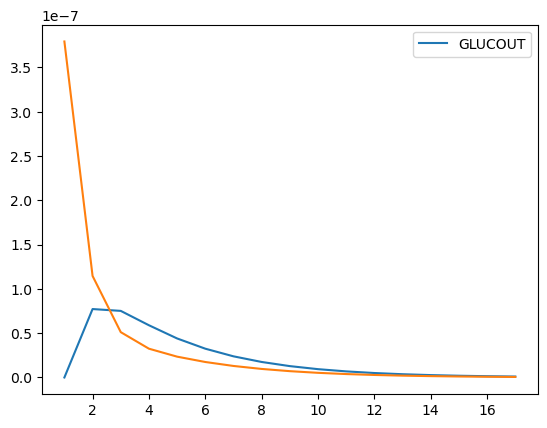

In [32]:
plt.plot(mech_bifurc.orig_time_sim_df['bifurc_0.00e+00_0001']['GLUCOUT'], label='GLUCOUT')
plt.plot(mech_bifurc.orig_time_sim_df['bifurc_0.00e+00_0001']['GLUCIN'])
plt.legend()

In [33]:
bifurc_df = build_bifurcation_df(mech_bifurc, bif_param_species="GLUCOUT")

In [ ]:
bifurc_df

,GLUCOUT_IC,PYRUVATE,AMPKA_ADP,LKB1,ULK,AKTA,GLUT1,MTORA,AMPK_ADP,AMPK_AMP,...,ADP,AMPKA,AMPKA_AMP,RHEBA,AMPK,AMPKA_ATP,GLUCOUT,GLUCIN,TSCA,AKT
bifurc_0.00e+00_0001,0.000000e+00,1.864950e-09,2.589480e-11,2.258830e-11,2.530270e-10,7.133130e-11,1.571700e-10,5.601860e-11,4.147350e-13,7.086840e-12,...,1.769980e-07,2.193490e-13,3.396850e-10,2.949200e-10,3.076720e-15,2.946550e-14,1.049410e-09,5.958820e-10,2.276790e-15,1.368060e-11
bifurc_1.00e-08_0001,1.000990e-08,1.976800e-09,2.642490e-11,2.258830e-11,2.530650e-10,7.133140e-11,1.571400e-10,5.607660e-11,4.241130e-13,7.091510e-12,...,1.807220e-07,2.192260e-13,3.391400e-10,2.949200e-10,3.082460e-15,3.074050e-14,1.112720e-09,6.317530e-10,2.273570e-15,1.368050e-11
bifurc_2.00e-08_0001,2.001990e-08,2.087750e-09,2.694230e-11,2.258830e-11,2.531020e-10,7.133130e-11,1.571110e-10,5.613320e-11,4.332880e-13,7.096140e-12,...,1.843590e-07,2.191070e-13,3.386070e-10,2.949200e-10,3.088120e-15,3.199850e-14,1.175540e-09,6.673440e-10,2.270420e-15,1.368060e-11
bifurc_3.00e-08_0001,3.002980e-08,2.201230e-09,2.745470e-11,2.258830e-11,2.531390e-10,7.133130e-11,1.570810e-10,5.618950e-11,4.424270e-13,7.100880e-12,...,1.879640e-07,2.189920e-13,3.380800e-10,2.949200e-10,3.093840e-15,3.327680e-14,1.239840e-09,7.037590e-10,2.267300e-15,1.368060e-11
bifurc_4.00e-08_0001,4.003980e-08,2.317360e-09,2.796310e-11,2.258830e-11,2.531750e-10,7.133130e-11,1.570500e-10,5.624540e-11,4.515420e-13,7.105720e-12,...,1.915420e-07,2.188790e-13,3.375560e-10,2.949200e-10,3.099620e-15,3.457460e-14,1.305680e-09,7.410430e-10,2.264210e-15,1.368060e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bifurc_9.96e-06_0001,9.959790e-06,7.052730e-07,3.885880e-15,2.258800e-11,2.911240e-10,7.133070e-11,1.445840e-11,2.635820e-10,1.070760e-13,1.292260e-18,...,1.266900e-11,2.057190e-15,1.051680e-19,2.949180e-10,1.311940e-11,3.100640e-14,4.805500e-06,3.483540e-07,2.709300e-20,1.368030e-11
bifurc_9.97e-06_0001,9.969800e-06,7.054990e-07,3.882890e-15,2.258800e-11,2.911240e-10,7.133060e-11,1.443480e-11,2.635820e-10,1.069980e-13,1.291430e-18,...,1.266030e-11,2.056880e-15,1.050880e-19,2.949180e-10,1.311940e-11,3.100190e-14,4.814300e-06,3.484770e-07,2.708700e-20,1.368040e-11
bifurc_9.98e-06_0001,9.979810e-06,7.057150e-07,3.879350e-15,2.258800e-11,2.911240e-10,7.133060e-11,1.441230e-11,2.635820e-10,1.068960e-13,1.288810e-18,...,1.264780e-11,2.056570e-15,1.048850e-19,2.949180e-10,1.311940e-11,3.099710e-14,4.823170e-06,3.485940e-07,2.708060e-20,1.368040e-11
bifurc_9.99e-06_0001,9.989820e-06,7.059370e-07,3.874630e-15,2.258800e-11,2.911240e-10,7.133060e-11,1.438910e-11,2.635820e-10,1.067660e-13,1.284820e-18,...,1.263250e-11,2.056120e-15,1.045610e-19,2.949180e-10,1.311940e-11,3.099040e-14,4.832010e-06,3.487150e-07,2.707200e-20,1.368050e-11


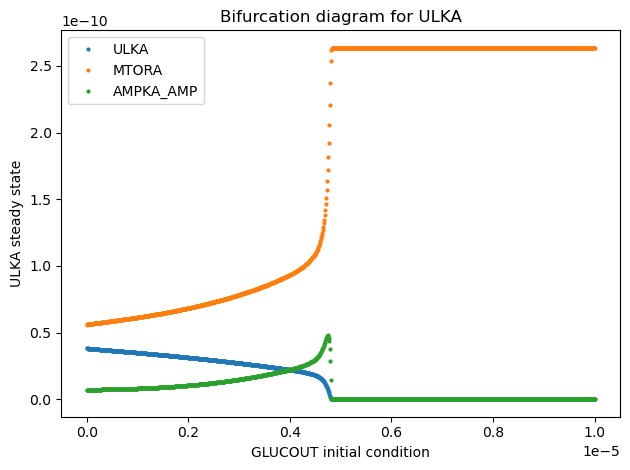

In [35]:
import matplotlib.pyplot as plt

species = "ULKA"
df = bifurc_df.sort_values("GLUCOUT_IC")  # sort for nicer plots
species2 = "MTORA"
df2 = bifurc_df.sort_values("GLUCOUT_IC")  # sort for nicer plots
species3 = "AMPK_AMP"
df3 = bifurc_df.sort_values("GLUCOUT_IC")  # sort for nicer plots

plt.figure()
plt.plot(df["GLUCOUT_IC"], df[species], ".", markersize=4, label='ULKA')
plt.plot(df2["GLUCOUT_IC"], df[species2], ".", markersize=4, label='MTORA')
plt.plot(df3["GLUCOUT_IC"], df[species3], ".", markersize=4, label='AMPKA_AMP')
plt.xlabel("GLUCOUT initial condition")
plt.ylabel(f"{species} steady state")
plt.title(f"Bifurcation diagram for {species}")
plt.legend()
plt.tight_layout()
plt.show()


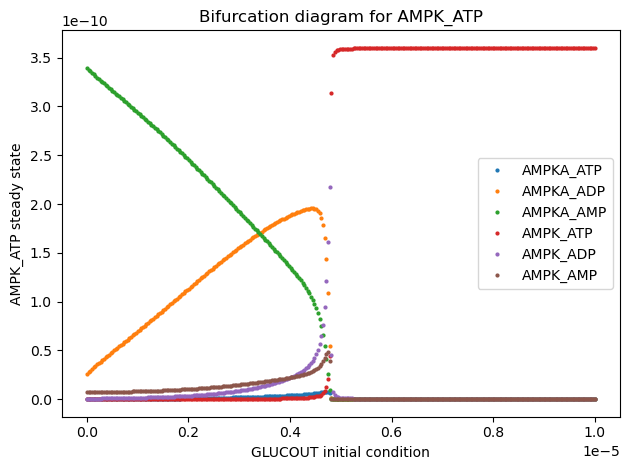

In [27]:
species1 = "AMPKA_ATP"
df = bifurc_df.sort_values("GLUCOUT_IC")  # sort for nicer plots
species2 = "AMPKA_ADP"
df2 = bifurc_df.sort_values("GLUCOUT_IC")  # sort for nicer plots
species3 = "AMPKA_AMP"
df3 = bifurc_df.sort_values("GLUCOUT_IC")  # sort for nicer plots
species4 = "AMPK_ATP"
df = bifurc_df.sort_values("GLUCOUT_IC")  # sort for nicer plots
species5 = "AMPK_ADP"
df2 = bifurc_df.sort_values("GLUCOUT_IC")  # sort for nicer plots
species6 = "AMPK_AMP"
df3 = bifurc_df.sort_values("GLUCOUT_IC")  # sort for nicer plots

plt.figure()
plt.plot(df["GLUCOUT_IC"], df[species1], ".", markersize=4, label='AMPKA_ATP')
plt.plot(df2["GLUCOUT_IC"], df[species2], ".", markersize=4, label='AMPKA_ADP')
plt.plot(df3["GLUCOUT_IC"], df[species3], ".", markersize=4, label='AMPKA_AMP')
plt.plot(df["GLUCOUT_IC"], df[species4], ".", markersize=4, label='AMPK_ATP')
plt.plot(df2["GLUCOUT_IC"], df[species5], ".", markersize=4, label='AMPK_ADP')
plt.plot(df3["GLUCOUT_IC"], df[species6], ".", markersize=4, label='AMPK_AMP')
plt.xlabel("GLUCOUT initial condition")
plt.ylabel(f"{species} steady state")
plt.title(f"Bifurcation diagram for {species}")
plt.legend()
plt.tight_layout()
plt.show()
